# WNS Analytics Wizard

Importing libraries

In [55]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Creating useful functions

In [56]:
def evaluate(actual, predicted, predicted_probability):
    print("Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(actual, predicted)))
    print("")
    print("For Class 1")
    print("f1 Score :", f1_score(actual, predicted))
    print("Precision Score :",precision_score(actual, predicted))
    print("Recall Score :",recall_score(actual, predicted))
    print("")
    print("For Class 0")
    print("f1 Score :", f1_score(1-np.array(actual), 1-np.array(predicted)))
    print("Precision Score :",precision_score(1-np.array(actual), 1-np.array(predicted)))
    print("Recall Score :",recall_score(1-np.array(actual), 1-np.array(predicted)))
    print("")
    print("AUROC :",  roc_auc_score(actual, predicted_probability[:,1]))

In [57]:
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    _ = plt.title('ROC')
    _ = plt.plot(fpr, tpr, 'b')
#     _ = plt.plot([0, 1], [0, 1],'r--', alpha=0.2)
    _ = plt.xlim([0, 1])
    _ = plt.ylim([0, 1])
    _ = plt.ylabel('True Positive Rate')
    _ = plt.xlabel('False Positive Rate')
    plt.show()

In [58]:
def generate_submission(impression_ids, is_clicks, method_name):
    submission_frame = pd.DataFrame(is_clicks, index=impression_ids)
    submission_frame.columns = ['is_click']
    submission_frame.index.name = 'impression_id'
    submission_frame.to_csv('data/test/'+method_name+'.csv')

In [59]:
def flow(X, y, training_func, X_future, y_future_ids):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)
    
    model = training_func(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    evaluate(y_test, y_pred, y_pred_prob)
    plot_roc(y_test, y_pred)
    
    y_future_pred = model.predict_proba(X_future)[:,1]
    generate_submission(y_future_ids, y_future_pred, training_func.__name__)
    
    return X_test, y_test, y_pred
    

In [68]:
feature_cols = ['app_code','os_version','app_click_ratio','overall_click_ratio','max_price','min_price',
                'total_items','total_unique_items','total_sessions','freq_product_type','freq_device',
                'freq_category_1','freq_category_2','freq_category_3']
category_cols = [0,1,9,10,11,12,13]

In [69]:
# Reading Training Data
training_df = pd.read_csv('data/train/train_with_feature.csv', index_col='impression_id')
X = training_df[feature_cols].values
y = training_df['is_click'].values
X[:1]

array([[4.220e+02, 0.000e+00, 0.000e+00, 0.000e+00, 2.350e+03, 2.350e+03,
        1.000e+00, 1.000e+00, 1.000e+00, 5.622e+03, 0.000e+00, 1.100e+01,
        3.500e+01, 2.000e+01]])

In [70]:
testing_df = pd.read_csv('data/test/test_with_feature.csv', index_col='impression_id')
X_future = testing_df[feature_cols].values
y_future_ids = testing_df.index.values
X_future.shape

(90675, 14)

## Trying LightGBM

best_estimator LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='auc', importance_type='split', learning_rate=0.1,
               max_depth=4, min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=33, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=14, objective=None, random_state=2019,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
best_score 0.7244867703075555
Confusion Matrix
       0  1
0  56615  4
1   2781  3

For Class 1
f1 Score : 0.002149767108563239
Precision Score : 0.42857142857142855
Recall Score : 0.0010775862068965517

For Class 0
f1 Score : 0.9759944834719648
Precision Score : 0.9531786652299818
Recall Score : 0.9999293523375545

AUROC : 0.7198295052907588


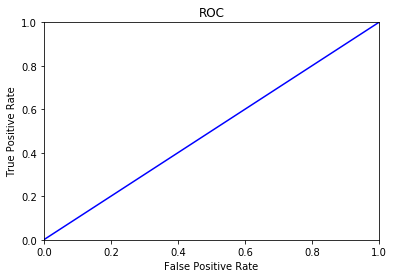

In [71]:
def tunned_light_gbm_ratio(X_train, y_train):
    lgb = LGBMClassifier(eval_metric = 'auc',random_state=2019)
    params = {
        'num_leaves': [14, 16, 18],
        'max_depth': [4],
        'min_data_in_leaf': [33, 35, 37]
    }
    lgb_grid = GridSearchCV(lgb, params, cv=10, scoring='roc_auc')
    lgb_grid.fit(X_train, y_train, categorical_feature=category_cols)
    print('best_estimator', lgb_grid.best_estimator_)
    print('best_score', lgb_grid.best_score_)
    return lgb_grid.best_estimator_

X_test, y_test, y_pred = flow(X, y, tunned_light_gbm_ratio, X_future, y_future_ids)

In [16]:
validate_test_df = pd.DataFrame(X_test)
validate_test_df.columns = ['os_version','click_ratio']
validate_test_df['expected'] = y_test
validate_test_df['actual'] = y_pred
validate_test_df.head()

,app_code,os_version,click_ratio,expected,actual
0,283.0,2.0,0.0,0,0
1,285.0,0.0,0.0,0,0
2,213.0,1.0,0.0,0,0
3,129.0,2.0,0.0,0,0
4,213.0,2.0,0.0,0,0


In [21]:
mismatch = validate_test_df[validate_test_df.expected != validate_test_df.actual]
mismatch.head()

,app_code,os_version,click_ratio,expected,actual
18,213.0,0.0,0.0,1,0
72,296.0,1.0,0.0,1,0
81,508.0,1.0,0.0,1,0
88,242.0,1.0,0.0,1,0
136,207.0,1.0,0.0,1,0


In [23]:
not_mismatch = validate_test_df[validate_test_df.expected == validate_test_df.actual]
not_mismatch.head()

,app_code,os_version,click_ratio,expected,actual
0,283.0,2.0,0.0,0,0
1,285.0,0.0,0.0,0,0
2,213.0,1.0,0.0,0,0
3,129.0,2.0,0.0,0,0
4,213.0,2.0,0.0,0,0


In [29]:
mismatch_app_code_count = mismatch.app_code.value_counts()
mismatch_app_code_count[mismatch_app_code_count > 5]

190.0    189
371.0    175
127.0    155
244.0    140
296.0    140
        ... 
259.0      6
443.0      6
120.0      6
424.0      6
390.0      6
Name: app_code, Length: 66, dtype: int64

In [27]:
app_code_count = training_df.app_code.value_counts()
app_code_count[app_code_count > 5]

207    33788
386    30706
190    17441
127    10851
371     9343
       ...  
210        6
161        6
406        6
55         6
191        6
Name: app_code, Length: 301, dtype: int64

In [18]:
false_positive[false_positive.app_code==275]

,app_code,os_version,click_ratio,expected,actual
5145,275.0,1.0,0.666667,0,1
20117,275.0,1.0,0.466667,0,1
52145,275.0,1.0,0.437500,0,1


In [95]:
training_df[(training_df.user_id==52382) & (training_df.click_ratio==0.0) & (training_df.app_code==207)]

,impression_time,user_id,app_code,os_version,is_4G,is_click,click_ratio
impression_id,,,,,,,
9f1f64b519d20e2ccc36e1589a8f7555,2018-11-15 11:09:00,52382,207,2,0,0,0.0
a41b3bb3e6b050b6c9067c67f663b915,2018-11-15 09:02:00,52382,207,2,0,0,0.0
c2eeaacb03e0bb62d5ffb626a9a3b79d,2018-11-23 16:04:00,52382,207,2,0,0,0.0
d6a65c9d345483ae4a545c748c66c9de,2018-11-27 08:59:00,52382,207,2,0,1,0.0


In [54]:
previous_record = time_series_user_data.loc[(52737, 32), :][:'2018-11-30 11:52:00'][:-1]
total_ads = previous_record.shape[0]
total_clicks = previous_record.is_click.sum()
(total_clicks / total_ads) if total_ads != 0 else 0.0

0.3333333333333333